In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from PIL import Image

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
# parameters

num_classes = 12

train_file = 'cnn/train.txt'
test_file = 'cnn/test.txt'

img_rows, img_cols = 64, 64

In [3]:
def load_images(image_paths, convert=False):
    
    x = []
    y = []
    for image_path in image_paths:
        
        path, label = image_path.split(' ')
        
        path= './cnn/data/' + path
        
        if convert:
            image_pil = Image.open(path).convert('RGB') 
        else:
            image_pil = Image.open(path).convert('L')
            
        img = np.array(image_pil, dtype=np.uint8)
        
        x.append(img)
        y.append([int(label)])
        
    x = np.array(x)
    y = np.array(y)
    
    if np.min(y) != 0:
        y = y-1
        
    return x, y

In [4]:
def load_dataset(train_file, test_file, resize, convert=False, size=(224,224)):
    
    arq = open(train_file, 'r')
    texto = arq.read()
    train_paths = texto.split('\n')
    
    print('Size : ', size)
    
    train_paths.remove('')    # remove empty lines
    train_paths.sort()
    x_train, y_train = load_images(train_paths, convert)
    
    arq = open(test_file, 'r')
    texto = arq.read()
    test_paths = texto.split('\n')
    
    test_paths.remove('')    # remove empty lines
    test_paths.sort()
    x_test, y_test = load_images(test_paths, convert)
    
    if resize:
        print("Resizing images...")
        x_train = resize_data(x_train, size, convert)
        x_test = resize_data(x_test, size, convert)
        
    if not convert:
        x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
        x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)
        
    print("Shape of train data:", np.shape(x_train))
    return (x_train, y_train), (x_test, y_test)

In [5]:
def resize_data(data, size, convert):
    
    if convert:
        data_upscaled = np.zeros((data.shape[0], size[0], size[1], 3))
    else:
        data_upscaled = np.zeros((data.shape[0], size[0], size[1]))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img
        
    print("Shape of data upscaled:", np.shape(data_upscaled))
    return data_upscaled

In [6]:
# gray scale
#input_shape = (img_rows, img_cols, 1)
#(x_train, y_train), (x_test, y_test) = load_dataset(train_file, test_file, resize=True, convert=False, size=(img_rows, img_cols))

# rgb
input_shape = (img_rows, img_cols, 3)
(x_train, y_train), (x_test, y_test) = load_dataset(train_file, test_file, resize=True, convert=True, size=(img_rows, img_cols))

Size :  (64, 64)
Resizing images...
Shape of data upscaled: (1578, 64, 64, 3)
Shape of data upscaled: (401, 64, 64, 3)
Shape of train data: (1578, 64, 64, 3)


In [7]:
### save for the confusion matrix
label = []
for i in range(len(x_test)):
    label.append(y_test[i][0])

In [8]:
#normalize images
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1578, 64, 64, 3)
1578 train samples
401 test samples


In [9]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
# create cnn model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
# print cnn layers
print('Network structure ----------------------------------')
for i, layer in enumerate(model.layers):
    print(i,layer.name)
    if hasattr(layer, 'output_shape'):
        print(layer.output_shape)
print('----------------------------------------------------')

Network structure ----------------------------------
0 conv2d_1
(None, 62, 62, 32)
1 conv2d_2
(None, 60, 60, 64)
2 max_pooling2d_1
(None, 30, 30, 64)
3 dropout_1
(None, 30, 30, 64)
4 flatten_1
(None, 57600)
5 dense_1
(None, 128)
6 dropout_2
(None, 128)
7 dense_2
(None, 12)
----------------------------------------------------


In [12]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=True, validation_data=(x_test, y_test))

Train on 1578 samples, validate on 401 samples
Epoch 1/20
1578/1578 [==============================] - 36s 23ms/step - loss: 3.7135 - acc: 0.1058 - val_loss: 2.3817 - val_acc: 0.1097
Epoch 2/20
1578/1578 [==============================] - 39s 25ms/step - loss: 2.3124 - acc: 0.1743 - val_loss: 2.1261 - val_acc: 0.2943
Epoch 3/20
1578/1578 [==============================] - 39s 25ms/step - loss: 2.0900 - acc: 0.2649 - val_loss: 1.8650 - val_acc: 0.4613
Epoch 4/20
1578/1578 [==============================] - 37s 23ms/step - loss: 1.8873 - acc: 0.3587 - val_loss: 1.7271 - val_acc: 0.5212
Epoch 5/20
1578/1578 [==============================] - 37s 24ms/step - loss: 1.6878 - acc: 0.4265 - val_loss: 1.5663 - val_acc: 0.4988
Epoch 6/20
1578/1578 [==============================] - 34s 22ms/step - loss: 1.4909 - acc: 0.4772 - val_loss: 1.3623 - val_acc: 0.6608
Epoch 7/20
1578/1578 [==============================] - 35s 22ms/step - loss: 1.3617 - acc: 0.5272 - val_loss: 1.3032 - val_acc: 0.6060
E

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.7980049878284521


In [15]:
pred = []
y_pred = model.predict_classes(x_test)
for i in range(len(x_test)):
    pred.append(y_pred[i])

In [16]:
print(confusion_matrix(label, pred))

[[29  4  0  0  0  2  3  0  0  0  1  0]
 [ 5 25  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 35  1  0  0  0  0  0  0  0  0]
 [ 0  0  1 36  1  0  0  1  0  0  0  0]
 [ 0  0  0  2 35  0  0  0  0  1  0  0]
 [ 3  0  0  0  0 24  2  0  0  0  0  0]
 [ 3  0  1  0  0  7 19  0  0  2  0  0]
 [ 0  1  0  0  0  0  0 20  0  0  1  6]
 [ 0  1  0  1  0  0  0  0 19  6  3  1]
 [ 0  0  0  0  0  0  0  0  1 29  0  0]
 [ 0  1  0  0  0  0  0  0  2  0 29  2]
 [ 0  4  0  0  0  1  0  1  4  3  0 20]]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


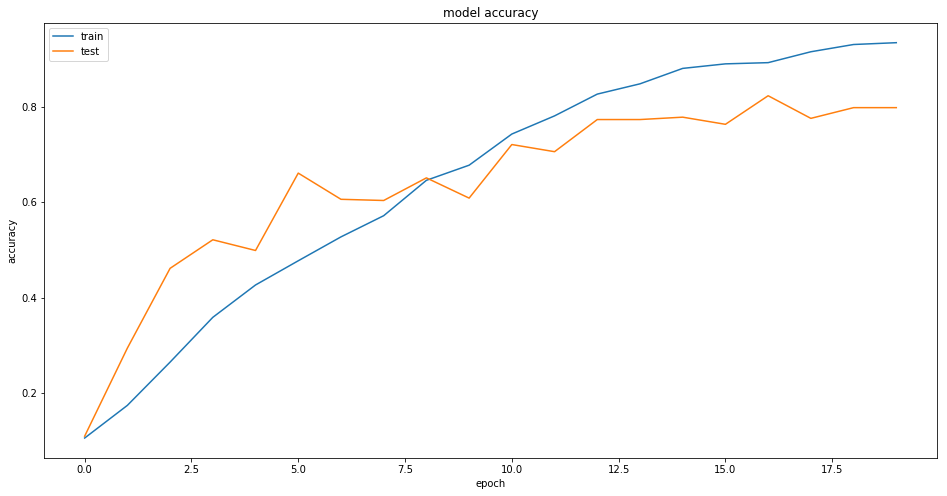

In [19]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(16, 8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


    A quantidade de neurônios na camada escondida
    Quantidade de camadas escondidas 
    Número de épocas de treinamento
    Overfitting da rede. Qual arquitetura (simples ou complexa) entra em overfitting com mais facilidade? 


Escreva um relatório avaliando os mesmo item do exercício anterior e também os parâmetros das camadas de convolução (tamanho do filtro, função de ativação, tipo de pooling, quantidade de camadas de convolução). Reporte seu melhor resultado juntamente com as matrizes de confusão

Sobre os itens do exercício anterior:

* A rede neural tem 128 neurônios na camada escondida, ou seja, uma proporção de 1-1 na quantidade de pixels em cada imagem

* A rede neural possui uma camada escondida com 128 neurônios

* A rede neural possui uma camada de saída com 12 neurônios (um para cada mês do ano) e uma função de ativação do tipo softmax, que garanti que a saída do modelo será uma das 12 categorias previamente definidas olhando a base de treino

* Possui 20 épocas de treinamento, cada uma demorando em média 40 segundos rodando em CPU (i5-4cores)

* A rede começou com um comportamento fora do usual, tendo uma acurácia na base de validação maior que na base de treino, o que acabou retornando ao normal a partir da oitava época

Sobre as camadas de convolução:

* A CNN começa com duas camadas de convolução, a primeiro com um filtro (a dimensionalidade do espaço de saída, ou seja, o número de filtros na convolução) de tamanho 32 e a segunda de tamanho 64, com um kernel de 3x3 em ambos os casos

* A camada seguinte é de Pooling do tipo Max, ou seja, pegando o valor máximo dentro do pool de valores, ainda, o tamanho do pool foi definido como um quadrado 2x2

* A camada seguinte é de Dropout, uma das maneiras de se previnir o overfitting no contexto de Deep Learning. Esta camada reduz a 0 uma fração de neurônios de entrada, sendo que definimos a fração como sendo 50%

* A camada final no contexto de convolução é a de Flatten, que "lineariza" a saída da camada anterior de um vetor com uma dimensão, para que a próxima camada consiga receber esta entrada

A acurácia final na base de validação foi de 79.8%